<a href="https://colab.research.google.com/github/wizard339/education/blob/main/nlp_cnn_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальное задание NLP-1. Векторные представления слов

В рамках данного задания вы отработаете навыки: 

*   Обработки текстовых данных
*   Написания и обучения токенизатора, который борется с проблемой OOV
*   Загрузки предобученных на большом языковом корпусе данных векторов
*   Имплементации статьи из arxiv для решения типовой задачи классификации текстов




После прохождения всех заданий вы также научитесь загружать предобученные веса и размораживать веса для дотренировки модели. Вы также используете библиотеку 🤗 Tokenizers для того, чтобы написать свой кастомный токенизатор и обучить его. 

В итоге вы напишете компакнутную нейронную сеть для задачи классификации, показывающую достаточно высокое качество, при этом совсем не требовательную к вычислительным ресурсам.

# Installing dependencies

**Тут есть важное действие, которое тебе нужно сделать перед тем, как запускать этот ноутбук**

Если вы делаете это задание в Google Colab, первым делом переключите Runtime в GPU. Это задание нормально посчитается и на CPU, но некоторые из будущих кейсов потребуют GPU (либо вам придётся несколько часов, или даже дней, чтобы модель обучилась — и мы не преувеличиваем). Ещё мы рекомендуем переключить язык интерфейса Colab на английский, потому что русская локализация ужасна, да и вообще не нужна.

[Тут](https://www.geeksforgeeks.org/how-to-use-google-colab/) о том, как переключить рантайм.

Для начала установим необходимые пакеты, перенаправив вывод с экрана в пустоту:

In [1]:
!pip install bpemb > /dev/null
!pip install datasets > /dev/null
!pip install tokenizers > /dev/null

В этом модуле вы познакомились с представлением слова как векторов. 
Вы, конечно, уже использовали векторные представления и работали с ними, но важно знать, с чего все начиналось, и какими инструментами пользовались раньше.

В этом кейсе мы не будем использовать WordNet, и даже Word2Vec — сейчас он уже устарел и практически не используется для реальных задач, но все же необходимо понимать его основные принципы, так как многие более современные модели основаны именно на нем. 

В качестве данных для задачи классификации будем использовать датасет об отзывах на фильмы и сериалы с сайта IMDB. В этом датасете данные разделены на две категории - положительный и негативный отзыв.




## Импортируем все необходимые библиотеки

In [2]:
import random
import collections
import os

from sklearn.model_selection import KFold

from bpemb import BPEmb

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import datasets

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## Загрузим данные

In [3]:
text_dataset = datasets.load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

**IMDB** — это датасет по классификации эмоциональной окраски. Вам нужно предсказать положительный ли отзыв к фильму по его тексту. Это довольно простая и распротранненая задача и она хорошо решается даже линейными моделями. Для доступа к нему мы используем библиотеку `datasets` - она содержит в себе много интересных текстовых датасетов.

Тренировочная и тестовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

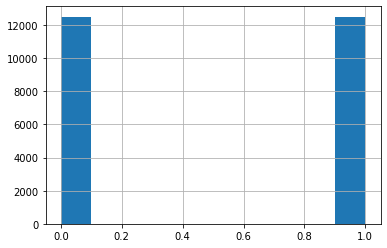

In [4]:
pd.DataFrame(text_dataset['train'], columns=['label', 'text'])['label'].hist();

## Задание 1

Давайте обучим свой SentencePiece токенизатор для нашего тренировочного датасета. Многие самые последние модели (Т5, XLNet, ALBERT), показывающие SoTA результаты в NLP, используют именно его.

In [5]:
from tokenizers import SentencePieceBPETokenizer

In [6]:
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

In [7]:
tokenizer = SentencePieceBPETokenizer(
    unk_token="<unk>",
    replacement="▁",
    add_prefix_space=True,
    dropout=0.9,
    fuse_unk=False,
)

Давайте посмотрим, как обрабатывает данные необученный токенизатор:

In [8]:
encoded = tokenizer.encode('Simple example of text')
encoded.ids, encoded.tokens

([], [])

Как видим, необученный токенизатор не умеет предобрабатывать данные

Обучите токенизатор, используя батчевую загрузку на данных тренировочного датасета (примените функцию train_from_iterator).

Для обучения используйте следующие параметры - размер словаря = 30000, минимальную частоту = 2, специальные токены из списка, который мы проинициализировали выше и префикс = '_'

In [9]:
# YOUR CODE STARTS
def batch_iterator(batch_size=1000):
  for i in range(0, len(text_dataset['train']), batch_size):
    yield text_dataset['train'][i: i + batch_size]['text']

tokenizer.train_from_iterator(
    iterator=batch_iterator(),
    vocab_size=30000,
    min_frequency=2,
    special_tokens=special_tokens
    )
# YOUR CODE ENDS

In [10]:
tokenizer.save_model('./')

['./vocab.json', './merges.txt']

Посмотрим как теперь обрабатывает текст токенизатор:

In [11]:
tokenizer = SentencePieceBPETokenizer('./vocab.json', './merges.txt')
encoded = tokenizer.encode('Simple example of text')
encoded.ids, encoded.tokens

([14860, 1718, 208, 5132], ['▁Simple', '▁example', '▁of', '▁text'])

Проверка успешности вашего кода:

In [12]:
tokenizer = SentencePieceBPETokenizer('./vocab.json', './merges.txt')
assert len(os.listdir('./')) >= 3
assert tokenizer.get_vocab_size() == 30000
assert len(tokenizer.encode('Simple example of text').ids) > 0

## Задание 2

Теперь перейдем к работе с предобученными языковыми векторами. В современных задачах NLP редко встречаются задачи, для которых необходимо с нуля обучать модель на данных только вашего тренировочного датасета. 

Используя предобученные вектора, мы можем использовать знание контекста слов в нашей задаче, а также если вдруг нам попадутся слова с опечатками, то по контексту мы сможем корректно их обработать.

Еще одним плюсом использования предобученных весов будет ускорение обучения модели, для достижения более точных результатов.

Так как мы используем датасет на английском языке, давайте скачаем вектора обученные на большом корпусе анлийского языка, и использующие BPE токенизацию.

Скачайте предобученные [BPE](https://github.com/bheinzerling/bpemb) эмбеддинги для английского языка, с размером словаря `vocab_size` и размеростью `dim`. 

In [13]:
vocab_size = 100000
dim = 300

In [14]:
# YOUR CODE STARTS
bpemb_en = BPEmb(lang='en', vs=vocab_size, dim=dim)
# YOUR CODE ENDS


Проверка успешности вашего кода:

In [15]:
assert bpemb_en is not None
assert bpemb_en.vectors.shape == (100000, 300)
assert bpemb_en.most_similar("skill")[2][1] > 0.3
assert bpemb_en.encode_ids('skillfactory') == [9725, 31214]

## Задание 3

Давайте освоим очень полезный навык — инициализацию линейного слоя специальными векторами. Это очень часто нужно, когда мы скачиваем предобученные веса, как, например, в нашем задании. 

Или другой пример: вам попалась обученная нейронная сеть, которая очень долго обучалась, но архитектура вашей сети немного отличается. Тогда вы можете взять веса из уже обученной сети, который совпадает по размерностям с вашей сетью, и немного дообучить остальные веса под вашу задачу.

Создадим 10 случайных векторов размерности 50, которые будут заменять нам предобученные эмбеддинги, и простой линейный слой таких же размерностей (10, 50).

In [16]:
some_vectors = torch.rand((10,50), dtype=torch.float32)

In [17]:
custom_layer = nn.Embedding(10, 50)

Проинициализируем веса линейного слоя сгенерированными ранее эмбеддингами:

In [18]:
custom_layer.weight = nn.Parameter(some_vectors.clone().detach().requires_grad_(True))

Создайте линейный слой и проинициализируйте его загруженными векторами BPE:

In [19]:
# YOUR CODE STARTS

embedding = nn.Embedding(*bpemb_en.vectors.shape)
bpemb_vectors = torch.tensor(bpemb_en.vectors)
embedding.weight = nn.Parameter(bpemb_vectors.clone().detach().requires_grad_(True))

# YOUR CODE ENDS

Проверим успешность вашего кода:

In [20]:
assert embedding is not None
assert embedding.weight.shape == (100000, 300)
assert embedding.weight.sum(axis=1)[23] < -6
assert embedding.weight[2] @ embedding.weight[22] > 1.6

## Задание 4

Давайте теперь освоим/закрепим еще один полезный навык — конкатенацию векторов и конкатенацию выходов слоев нейронной сети. 

Это также необходимое знание, потому что механизм skip connections по сути реализован за счет конкатенации выходов с предыдущего слоя нейронной сети с выходом текущего слоя.

Основная цель конкатенации: добавить информации с предыдущих слоев в общий вектор, чтобы в нем содержалась информация разного масштаба (одни свертки проходят меньшим окном по тексту, другие бОльшим).

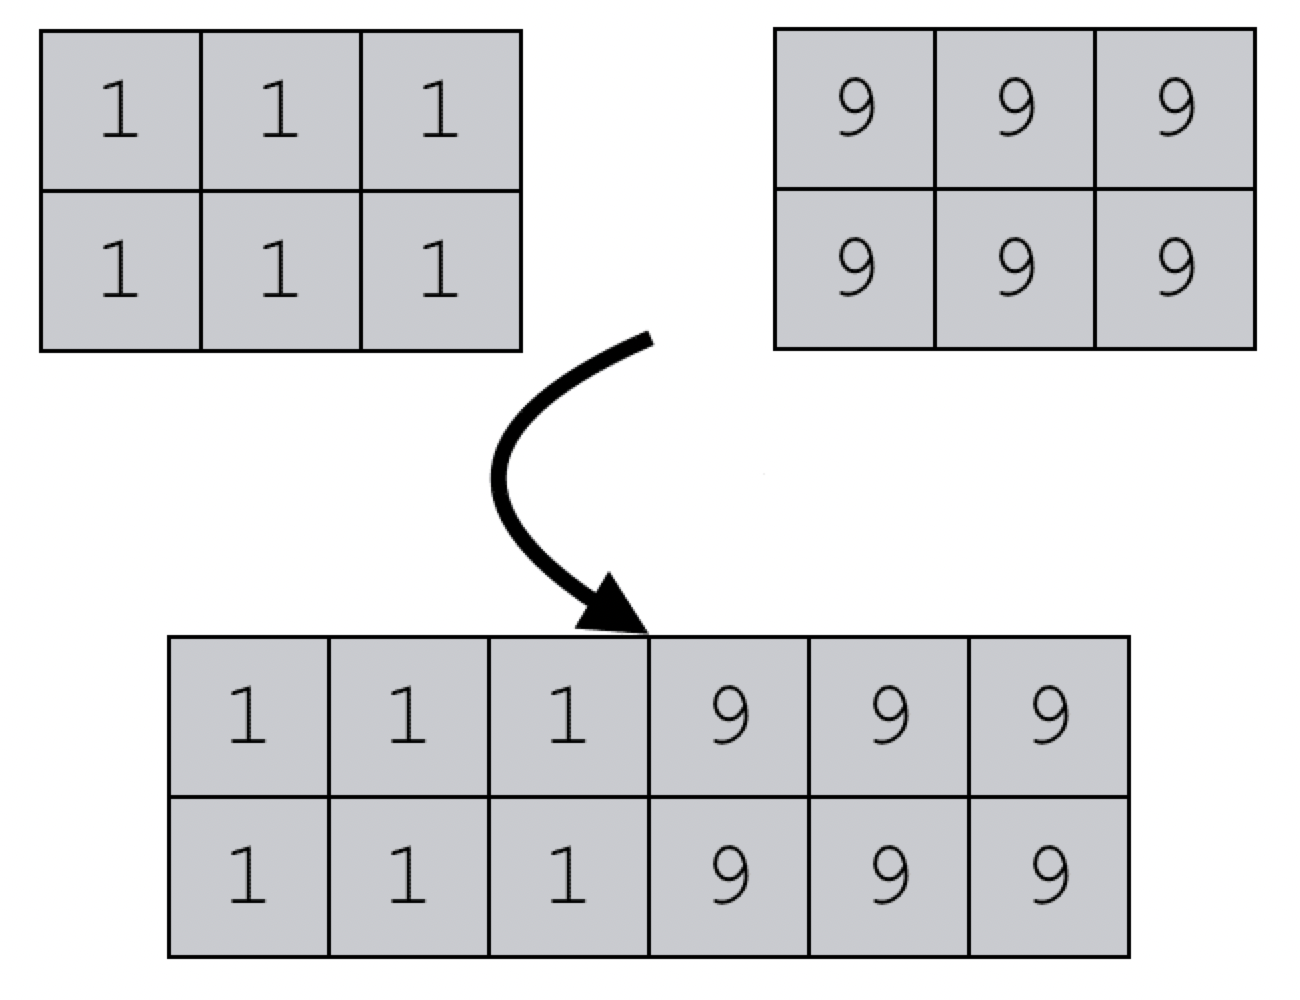

Напишем крошечную нейронную сеть, состоящую из линейного слоя, пары сверточных слоев и одного выходного слоя. Как вы уже догадались, сверточные слои мы будем конкатенировать друг с другом.

In [21]:
class SimpleNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_classes, n_filters):
    super(SimpleNN, self).__init__()

    self.kernel_num = n_filters

    self.embedding = nn.Embedding(input_dim, hidden_dim)

    self.embedding.weight.requires_grad = False  # по желанию мы можем заморозить веса некоторого слоя, чтобы не обучать их,
                                                 # а через несколько эпох обучения разморозить

    self.conv1 = nn.Conv2d(1, self.kernel_num, (2, hidden_dim))
    self.conv2 = nn.Conv2d(1, self.kernel_num, (4, hidden_dim))

    self.dropout = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(2 * self.kernel_num, n_classes)  # 2 * self.kernel_num - после конкатенации мы вытянем в один вектор оба выхода сверточной сети


  def forward(self, x):
    x = self.embedding(x)
    x = x.unsqueeze(1)  # добавим одну размерность, потому что у сверточных слоев есть параметр "количество фильтров"
    
    conv_out_1 = F.relu(self.conv1(x)).squeeze(3)  # последняя размерность получилась после применения свертки, она нам больше не нужна
    conv_out_2 = F.relu(self.conv2(x)).squeeze(3)

    conv_out_1 = F.max_pool1d(conv_out_1, conv_out_1.size(2)).squeeze(2)  # используем MaxPooling, потому что нам нужно смотреть на весь текст,
                                                                          #  а не на конкретный фильтр, как это было в сверточных сетях в CV
    conv_out_2 = F.max_pool1d(conv_out_2, conv_out_2.size(2)).squeeze(2)

    x = torch.cat([conv_out_1, conv_out_2], 1)

    x = self.dropout(x)
    logit = self.fc1(x)

    return logit

In [22]:
net = SimpleNN(100, 30, 2, 50)
[len(param) for param in net.parameters() if param.requires_grad == True]

[50, 50, 50, 50, 2, 2]

Напишите класс для нейронной сети, которая будет принимать на вход параметры: входная размерность, размерность скрытого слоя, количество классов, количество фильтров для сверточных слоев и матрица векторов.

Проинициализируйте линейный слой векторами предобученных эмбеддингов и заморозьте веса этого слоя.

У сети должно быть два сверточных слоя с kernel size 2 и 4.
Количество фильтров должно быть равным 100.
Количество классов оставим равным 2.

In [23]:
class TaskNN(nn.Module):
  def __init__(self,
               input_dim, hidden_dim,
               n_classes, n_filters, embedding_matrix):
    # YOUR CODE STARTS

    super(TaskNN, self).__init__()

    self.kernel_num = n_filters

    self.embedding = nn.Embedding(input_dim, hidden_dim)
    self.embedding.weights = nn.Parameter(embedding_matrix.clone().detach())
    self.embedding.weights.requires_grad = False

    self.conv1 = nn.Conv2d(1, self.kernel_num, (2, hidden_dim))
    self.conv2 = nn.Conv2d(1, self.kernel_num, (4, hidden_dim))

    self.dropout = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(2 * self.kernel_num, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x = x.unsqueeze(1)

    conv_out_1 = F.relu(self.conv1(x)).squeeze(3)
    conv_out_2 = F.relu(self.conv2(x)).squeeze(3)

    conv_out_1 = F.max_pool1d(conv_out_1, conv_out_1.size(2)).squeeze(2)
    conv_out_2 = F.max_pool1d(conv_out_2, conv_out_2.size(2)).squeeze(2)

    x = torch.cat([conv_out_1, conv_out_2], 1)

    x = self.dropout(x)
    logit = self.fc1(x)

    return logit
    # YOUR CODE ENDS

In [24]:
# assert 
task_model = TaskNN(vocab_size, dim, 2, 100, bpemb_vectors)
assert sum([len(param) for param in task_model.parameters() if param.requires_grad == True]) == 100404
assert sum([len(param) for param in task_model.parameters() if param.requires_grad == False]) == 100000

## Подготовим данные

Давайте посмотрим на наши данные пристальнее:

In [25]:
l = list()
for text in tqdm(text_dataset['train']['text']):
    l.append(len(bpemb_en.encode_ids(text.lower())))

  0%|          | 0/25000 [00:00<?, ?it/s]

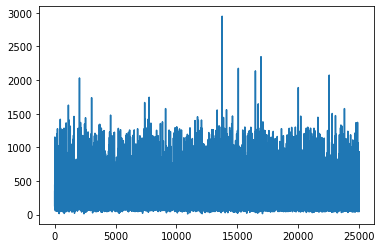

In [26]:
pd.Series(l).plot()

Видно, что 90% текстов не превышают 1500 токенов. Давайте возьмем с запасом квантиль 0.95 и проинициализируем этим значением переменную max_len.

In [27]:
# YOUR CODE STARTS

max_len = np.quantile(l, 0.95)

# YOUR CODE ENDS

In [28]:
assert max_len > 700 and max_len < 1000

Давайте напишем небольшой класс-надстройку над текущим датасетом, которым сразу будет нам выдавать токенизированные векторы текста.

In [29]:
class CustomDataset:
  def __init__(self, data, targets, tokenizer, max_len=max_len):
    self.data = data
    self.targets = targets
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text = self.data[idx]
    label = self.targets[idx]

    input_ids = np.zeros((int(max_len),))
    row = self.tokenizer(text.lower())
    for j, id in enumerate(row):
      if j < max_len:
        input_ids[j] = id
    
    return {
        'text': torch.tensor(input_ids, dtype=torch.long),
        'label': torch.tensor(label, dtype=torch.long)
    }

Создайте экземпляр класса для тренировочного и валидационного датасета, передав в качестве токенизатора функцию токенизации из `bpemb_en`:

In [30]:
# YOUR CODE STARTS

train_dataset = CustomDataset(
    text_dataset['train']['text'],
    text_dataset['train']['label'],
    tokenizer=bpemb_en.encode_ids
    )
test_dataset = CustomDataset(
    text_dataset['test']['text'],
    text_dataset['test']['label'],
    tokenizer=bpemb_en.encode_ids
    )

# YOUR CODE ENDS

Проверим успешность вашего кода:

In [31]:
assert train_dataset is not None
assert test_dataset is not None
assert len(train_dataset) == 25000
assert torch.tensor(train_dataset.tokenizer('some simple text!'), dtype=torch.float32).mean() > 26800

Напишем теперь наш класс нейронной сети для классификации текста.<br> 

Используйте предобученные BPE эмбеддинги для инициализации линейного слоя на входе. <br>

Предлагаю использовать связку из нескольких сверточных слоев, которые будем конкатенировать. Наша простая сеть, написанная ранее может в этом помочь.<br>

Как ни удивительно, но сверточные сети [неплохо себя показывают](https://aclweb.org/anthology/D14-1181.pdf) при решении задач классификации текста.

In [32]:
# YOUR CODE STARTS

class ConvNet(nn.Module):
  def __init__(self,
               input_dim, hidden_dim,
               n_classes, n_filters, embedding_matrix):

    super(ConvNet, self).__init__()

    self.kernel_num = n_filters

    self.embedding = nn.Embedding(input_dim, hidden_dim)
    self.embedding.weights = nn.Parameter(embedding_matrix.clone().detach())
    self.embedding.weights.requires_grad = False

    self.conv1 = nn.Conv2d(1, self.kernel_num, (2, hidden_dim))
    self.conv2 = nn.Conv2d(1, self.kernel_num, (4, hidden_dim))

    self.dropout = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(2 * self.kernel_num, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x = x.unsqueeze(1)

    conv_out_1 = F.relu(self.conv1(x)).squeeze(3)
    conv_out_2 = F.relu(self.conv2(x)).squeeze(3)

    conv_out_1 = F.max_pool1d(conv_out_1, conv_out_1.size(2)).squeeze(2)
    conv_out_2 = F.max_pool1d(conv_out_2, conv_out_2.size(2)).squeeze(2)

    x = torch.cat([conv_out_1, conv_out_2], 1)

    x = self.dropout(x)
    logit = self.fc1(x)

    return logit

model = ConvNet(vocab_size, dim, 2, 100, bpemb_vectors)

# YOUR CODE ENDS

Осталось написать train_loop и eval_loop и можно начинать обучение модели.

In [33]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    start_time = time.time()

    for idx, batch in enumerate(tqdm(dataloader)):
        text = batch['text'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()
        predited_label = model(text)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        predited_label = predited_label.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        total_acc += accuracy(predited_label, label)
        total_count += len(label)
    elapsed = time.time() - start_time
    print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
    total_acc, total_count = 0, 0
    start_time = time.time()

In [34]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            predited_label = model(text)
            loss = criterion(predited_label, label)
            predited_label = predited_label.detach().cpu().numpy()
            label = label.to('cpu').numpy()
            total_acc += accuracy(predited_label, label)
            total_count += len(label)
    return total_acc/total_count

Не забудем написать метод для рассчета `accuracy`! 

In [35]:
def accuracy(probs, targets):
    """
    Args:
        probs: torch.FloatTensor[batch_size, 1], probabilities of positive class
        targets: torch.LongTensor[batch_size, 1], true classes

    Returns:
        0 <= float <= 1, proportion of correct predictions
    """
    return np.sum(probs==targets) / len(targets)


    # YOUR CODE

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

In [37]:
from torch.utils.data.dataset import random_split
import time

# гиперпараметры
EPOCHS = 2
LR = 3e-4 
BATCH_SIZE = 32

model = ConvNet(vocab_size, dim, 2, 300, bpemb_vectors).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
total_accu = None

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True)


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    if epoch == 4:  # разморозим веса наших эмбеддингов, чтобы немного донастроить модель под нашу задачу
      model.embedding.weight.requires_grad = True
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

  0%|          | 0/743 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
<ipython-input-35-0b5ccb1e6717>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(probs==targets) / len(targets)


| epoch   1 |   742/  743 batches | accuracy    0.000
-----------------------------------------------------------
| end of epoch   1 | time: 70.52s | valid accuracy    0.000 
-----------------------------------------------------------


  0%|          | 0/743 [00:00<?, ?it/s]

RuntimeError: ignored

`accuracy` нашей модели на валидационной части датасета в идеале должно быть больше 0.88, но точно меньше 1.

Если вы получили низкое значение — проверьте написанную вами модель. Возможно, вы забыли перемешать ваш тренировочный датасет? 

In [ ]:
positive_comment = 'This movie is awesome!'
negative_comment = 'This movie is very very bad!'
neutral_comment = 'This is so-so'

_dataset = CustomDataset([positive_comment, negative_comment, neutral_comment], [0] * 3, lambda x: bpemb_en.encode_ids(x))
_dataloader = torch.utils.data.DataLoader(_dataset, batch_size=32)

_x = next(iter(_dataloader))['text'].to(device)
probs = torch.softmax(model(_x), 1).detach().cpu().numpy()

print(np.round(probs, 3))

print(f'Probability of "{positive_comment}" to be positive -- {probs[0][1]}')
print(f'Probability of "{negative_comment}" to be positive -- {probs[1][0]}')
print(f'Probability of "{neutral_comment}" to be positive -- {probs[2][0]}')

del _dataset, _dataloader 